# Locally connected module for sqptn1 tasks

In [1]:
from ay_torch import *
import os

In [23]:
'''
in_shape: Tuple or list of (in_channels, in_h, in_w).
'''
class TLocallyConnected2d(torch.nn.Module):
  def __init__(self, in_shape, out_channels, kernel_size, stride=1, padding=0, bias=True, padding_mode='zeros', device=None, dtype=None):
    super(TLocallyConnected2d, self).__init__()
    self.kernel_size= torch.nn.modules.utils._pair(kernel_size)
    self.stride= torch.nn.modules.utils._pair(stride)
    self.padding= torch.nn.modules.utils._pair(padding)
    out_h= int((in_shape[1]+2*self.padding[0]-1*(self.kernel_size[0]-1)-1)/self.stride[0]+1)
    out_w= int((in_shape[2]+2*self.padding[1]-1*(self.kernel_size[1]-1)-1)/self.stride[1]+1)
    self.out_shape= (out_h,out_w)
    valid_padding_modes= {'zeros', 'reflect', 'replicate', 'circular'}
    assert(padding_mode in valid_padding_modes)
    self.padding_mode= padding_mode
    factory_kwargs= dict(device=device, dtype=dtype)
    self.weight= torch.nn.Parameter(torch.empty((out_channels,in_shape[0])+self.out_shape+self.kernel_size, **factory_kwargs))
    if bias:
      self.bias= torch.nn.Parameter(torch.empty((out_channels,)+self.out_shape, **factory_kwargs))
    else:
      self.register_parameter('bias', None)

  def forward(self, x):
    view_shape= x.shape[:2]+self.out_shape+self.kernel_size
    if self.padding_mode=='zeros':
      x= torch.nn.functional.pad(x, tuple(p for p in reversed(self.padding) for _ in range(2)), mode='constant', value=0.0)
    else:
      x= torch.nn.functional.pad(x, tuple(p for p in reversed(self.padding) for _ in range(2)), mode=padding_mode)
    strides= x.stride()[:2]+tuple(np.array(x.stride()[2:])*self.stride)+x.stride()[2:]
    sub_matrices= torch.as_strided(x, view_shape, strides)
    x= torch.einsum('ijmnkl,bjmnkl->bimn', self.weight, sub_matrices)
    return x if self.bias is None else x+self.bias

def LocallyConnectedLayer2d(in_shape, out_channels, kernel_size, stride=1,
              padding=None, bias=True, padding_mode='zeros',
              norm_type='batch', batchnorm_first=True,
              activation=torch.nn.LeakyReLU, init='auto', bias_std=0.5):
  bn= norm_type in ('batch', 'batch_zero')
  if padding is None: padding= (kernel_size-1)//2
  lc= TLocallyConnected2d(in_shape, out_channels, kernel_size, stride=stride, padding=padding, bias=bias, padding_mode=padding_mode)
  act= (None if activation is None else
        activation(inplace=True) if activation in (torch.nn.ReLU,torch.nn.ReLU6,torch.nn.LeakyReLU) else
        activation())
  if getattr(lc,'bias',None) is not None and bias_std is not None:
    if bias_std!=0: torch.nn.init.normal_(lc.bias, 0.0, bias_std)
    else: lc.bias.data.zero_()
  f_init= None
  if act is not None and init=='auto':
    if hasattr(act.__class__, '__default_init__'):
      f_init= act.__class__.__default_init__
    else:  f_init= getattr(act, '__default_init__', None)
    if f_init is None and act in (torch.nn.ReLU,torch.nn.ReLU6,torch.nn.LeakyReLU):
      f_init= torch.nn.init.xavier_uniform_  #FIXME: Consider the initialization of weight.
  if f_init is not None: f_init(lc.weight,gain=torch.nn.init.calculate_gain('leaky_relu'))
  if   norm_type=='weight':   lc= torch.nn.utils.weight_norm(lc)
  elif norm_type=='spectral': lc= torch.nn.utils.spectral_norm(lc)
  layers= [lc]
  act_bn= []
  if act is not None: act_bn.append(act)
  if bn:
    bnl= torch.nn.BatchNorm2d(out_channels)
    if bnl.affine:
      bnl.bias.data.fill_(1e-3)
      bnl.weight.data.fill_(0. if norm_type=='batch_zero' else 1.)
    act_bn.append(bnl)
  if batchnorm_first: act_bn.reverse()
  layers+= act_bn
  return torch.nn.Sequential(*layers)

class TResLCBlock2d(torch.nn.Module):
  def __init__(self, in_shape, out_channels, kernel_size, stride=1,
               hidden_channels=None, pattern=['LC','Conv'], id_mod='LC',
               activation=torch.nn.LeakyReLU, lc_args=None, conv_args=None):
    super(TResLCBlock2d,self).__init__()
    default_lc_args= dict()
    lc_args= MergeDict(default_lc_args,lc_args) if lc_args else default_lc_args
    default_conv_args= dict(ndim=2)
    conv_args= MergeDict(default_conv_args,conv_args) if conv_args else default_conv_args
    if hidden_channels is None: hidden_channels= out_channels
    lcpath= []
    for i,m in enumerate(pattern):
      stride2= stride if i==0 else 1
      activation2= None if i==len(pattern)-1 else activation
      in_shape2= torch.nn.Sequential(*lcpath)(torch.zeros((3,)+in_shape)).shape[1:]
      out_channels2= out_channels if i==len(pattern)-1 else hidden_channels
      if m=='LC':
        mod= LocallyConnectedLayer2d(in_shape2, out_channels2, kernel_size, stride=stride2, activation=activation2, **lc_args)
      elif m=='Conv':
        mod= ConvLayer(in_shape2[0], out_channels2, kernel_size, stride=stride2, activation=activation2, **conv_args)
      lcpath.append(mod)
    self.lcpath= torch.nn.Sequential(*lcpath)
    idpath= []
    if in_shape[0]!=out_channels or stride!=1:
      if id_mod=='LC':
        idpath.append(LocallyConnectedLayer2d(in_shape, out_channels, kernel_size=stride, stride=stride, activation=None, **lc_args))
      elif id_mod=='Conv':
        if in_shape[0]!=out_channels:
          idpath.append(ConvLayer(in_shape[0], out_channels, kernel_size=1, activation=None, **conv_args))
        if stride!=1:
          pool= torch.nn.AvgPool2d
          pool_first= True
          idpath.insert((1,0)[pool_first], pool(kernel_size=stride, stride=None, padding=0, ceil_mode=True))
    self.idpath= torch.nn.Sequential(*idpath)
    self.act= activation(inplace=True) if activation in (torch.nn.ReLU,torch.nn.ReLU6,torch.nn.LeakyReLU) else activation()

  def forward(self, x):
    return self.act(self.lcpath(x) + self.idpath(x))

class TResFlexNet2d(torch.nn.Sequential):
  def __init__(self, in_shape, layers, kernel_size=3, 
               conv_args=None, res_args=None, lc_args=None, reslc_args=None):
    default_conv_args= dict(kernel_size=kernel_size, ndim=2)
    conv_args= MergeDict(default_conv_args,conv_args) if conv_args else default_conv_args
    default_res_args= dict(kernel_size=kernel_size, ndim=2)
    res_args= MergeDict(default_res_args,res_args) if res_args else default_res_args
    default_lc_args= dict(kernel_size=kernel_size)
    lc_args= MergeDict(default_lc_args,lc_args) if lc_args else default_lc_args
    default_reslc_args= dict(kernel_size=kernel_size)
    reslc_args= MergeDict(default_reslc_args,reslc_args) if reslc_args else default_reslc_args
    blocks= []
    for l in layers:
      if isinstance(l,tuple):
        type,args= l
        h_shape= torch.nn.Sequential(*blocks)(torch.zeros((3,)+in_shape)).shape[1:]
        if type=='Conv':  mod= ConvLayer(h_shape[0], **MergeDict(copy.deepcopy(conv_args),args))
        elif type=='Res':  mod= TResBlock(**MergeDict(MergeDict(copy.deepcopy(res_args),args),dict(expansion=1,in_channels=h_shape[0])))
        elif type=='LC':  mod= LocallyConnectedLayer2d(h_shape, **MergeDict(copy.deepcopy(lc_args),args))
        elif type=='ResLC':  mod= TResLCBlock2d(h_shape, **MergeDict(copy.deepcopy(reslc_args),args))
        elif type=='Linear':  mod= torch.nn.Linear(h_shape[0], **args)
      else:
        mod= l
      blocks.append(mod)
    super(TResFlexNet2d,self).__init__(*blocks)


In [3]:
in_size= (3,200,200)
input=torch.randn((3,)+in_size)
# print(input)
print(Summary(TResLCBlock2d(in_size, 5, kernel_size=3, stride=2), input_data=input), '\n')
print(Summary(TResBlock(expansion=1, in_channels=in_size[0], out_channels=5, kernel_size=3, stride=2), input_data=input))

input_data.shape=torch.Size([3, 3, 200, 200])
Layer (type (var_name))                  Input Shape               Output Shape              Param #
TResLCBlock2d                            --                        --                        --
├─Sequential (lcpath)                    [3, 3, 200, 200]          [3, 5, 100, 100]          --
│    └─Sequential (0)                    [3, 3, 200, 200]          [3, 5, 100, 100]          --
│    │    └─TLocallyConnected2d (0)      [3, 3, 200, 200]          [3, 5, 100, 100]          1,400,000
│    │    └─BatchNorm2d (1)              [3, 5, 100, 100]          [3, 5, 100, 100]          10
│    │    └─LeakyReLU (2)                [3, 5, 100, 100]          [3, 5, 100, 100]          --
│    └─Sequential (1)                    [3, 5, 100, 100]          [3, 5, 100, 100]          --
│    │    └─Conv2d (0)                   [3, 5, 100, 100]          [3, 5, 100, 100]          225
│    │    └─BatchNorm2d (1)              [3, 5, 100, 100]          [3, 5, 100

In [5]:
in_shape= (3,64,64)
input=torch.randn((3,)+in_shape)

# Equivalent to TResNet18
kernel_size= 3
p_dropout= 0.0
rfn_args_resnet18= dict(
  kernel_size=kernel_size,
  layers=[
    ('Conv',dict(out_channels=32,stride=1)),
    ('Conv',dict(out_channels=32,stride=2)),
    ('Conv',dict(out_channels=64,stride=2)),
    torch.nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=kernel_size//2),
    ('Res',dict(out_channels=64,stride=1)),
    ('Res',dict(out_channels=64,stride=1)),
    ('Res',dict(out_channels=128,stride=1)),
    ('Res',dict(out_channels=128,stride=2)),
    ('Res',dict(out_channels=256,stride=1)),
    ('Res',dict(out_channels=256,stride=2)),
    ('Res',dict(out_channels=512,stride=1)),
    ('Res',dict(out_channels=512,stride=2)),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(p_dropout),
    ('Linear',dict(out_features=3)),
    ], )
Summary(TResFlexNet2d(in_shape, **rfn_args_resnet18), input_data=input)
# TResFlexNet2d(in_shape, layers, kernel_size=kernel_size)(input)

input_data.shape=torch.Size([3, 3, 64, 64])


Layer (type (var_name))                  Input Shape               Output Shape              Param #
TResFlexNet2d                            --                        --                        --
├─Sequential (0)                         [3, 3, 64, 64]            [3, 32, 64, 64]           --
│    └─Conv2d (0)                        [3, 3, 64, 64]            [3, 32, 64, 64]           864
│    └─BatchNorm2d (1)                   [3, 32, 64, 64]           [3, 32, 64, 64]           64
│    └─ReLU (2)                          [3, 32, 64, 64]           [3, 32, 64, 64]           --
├─Sequential (1)                         [3, 32, 64, 64]           [3, 32, 32, 32]           --
│    └─Conv2d (0)                        [3, 32, 64, 64]           [3, 32, 32, 32]           9,216
│    └─BatchNorm2d (1)                   [3, 32, 32, 32]           [3, 32, 32, 32]           64
│    └─ReLU (2)                          [3, 32, 32, 32]           [3, 32, 32, 32]           --
├─Sequential (2)               

In [6]:
Summary(TResNet18(out_channels=3), input_data=input)

input_data.shape=torch.Size([3, 3, 64, 64])


Layer (type (var_name))                       Input Shape               Output Shape              Param #
TResNet                                       --                        --                        --
├─Sequential (0)                              [3, 3, 64, 64]            [3, 32, 64, 64]           --
│    └─Conv2d (0)                             [3, 3, 64, 64]            [3, 32, 64, 64]           864
│    └─BatchNorm2d (1)                        [3, 32, 64, 64]           [3, 32, 64, 64]           64
│    └─ReLU (2)                               [3, 32, 64, 64]           [3, 32, 64, 64]           --
├─Sequential (1)                              [3, 32, 64, 64]           [3, 32, 32, 32]           --
│    └─Conv2d (0)                             [3, 32, 64, 64]           [3, 32, 32, 32]           9,216
│    └─BatchNorm2d (1)                        [3, 32, 32, 32]           [3, 32, 32, 32]           64
│    └─ReLU (2)                               [3, 32, 32, 32]           [3, 32, 32

# Test TResFlexNet2d on CIFAR-10

## CIFAR-10 Setup

In [7]:
def GetDataTransforms(mode):
  if mode=='train':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(460),
        torchvision.transforms.Pad(20, padding_mode='constant'),  #'reflect'
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomAffine(degrees=10, scale=(1.,1.1), shear=(-0.2,0.2,-0.2,0.2)),
        torchvision.transforms.CenterCrop(460),
        torchvision.transforms.RandomResizedCrop(224, scale=(0.75,1.), ratio=(1.,1.)),
        torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0, hue=0),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='test':
    return torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor(),
      ])
  if mode=='none':
    return torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor()
      ])

In [8]:
dset_train= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=True,
              transform=GetDataTransforms('train'),
              download=True)
dset_test= torchvision.datasets.CIFAR10(
              root='./data_downloaded/',
              train=False,
              transform=GetDataTransforms('test'),
              download=True)
#NOTE: Adjust the batch size.
n_batch= 64
dl_train= torch.utils.data.DataLoader(
              dataset=dset_train,
              batch_size=n_batch,
              shuffle=True,
              num_workers=2)
dl_test= torch.utils.data.DataLoader(
              dataset=dset_test,
              batch_size=n_batch,
              shuffle=False,
              num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
print('dset_train size:',len(dset_train))
print('dset_train[0] input type, shape:',type(dset_train[0][0]),dset_train[0][0].shape)
print('dset_train[0] label value:',dset_train[0][1],type(dset_train[0][1],),dset_train.classes[dset_train[0][1]])
print('dset_train[0][0] value range:',torch.min(dset_train[0][0]),torch.max(dset_train[0][0]))
print('dset_test size:',len(dset_test))
print('dset_test[0] input type, shape:',type(dset_test[0][0]),dset_test[0][0].shape)
print('dset_test[0] label value:',dset_test[0][1],dset_test.classes[dset_test[0][1]])

dset_train size: 50000
dset_train[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_train[0] label value: 6 <class 'int'> frog
dset_train[0][0] value range: tensor(0.0588) tensor(0.9490)
dset_test size: 10000
dset_test[0] input type, shape: <class 'torch.Tensor'> torch.Size([3, 224, 224])
dset_test[0] label value: 3 cat


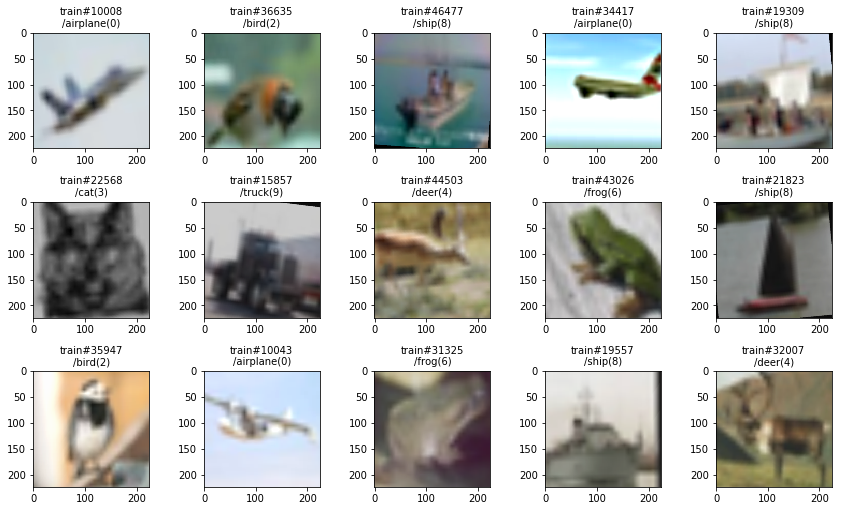

In [10]:
d= dset_train
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
labels= [f'train#{i}\n/{d.classes[d[i][1]]}({d[i][1]})' for i in idxes]
PlotImgGrid(imgs, labels)

## TResFlexNet2d(ResNet18)

In [11]:
#Setup a neural network.
in_shape= dset_train[0][0].shape
rfn_args_resnet18['layers'][-1][1]['out_features']= len(dset_train.classes)
net= TResFlexNet2d(in_shape, **rfn_args_resnet18)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [12]:
input_size= (1,)+dset_train[0][0].shape
print(f'input_size={input_size}')
torchinfo.summary(net, input_size)

input_size=(1, 3, 224, 224)


Layer (type:depth-idx)                   Output Shape              Param #
TResFlexNet2d                            --                        --
├─Sequential: 1-1                        [1, 32, 224, 224]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         864
│    └─BatchNorm2d: 2-2                  [1, 32, 224, 224]         64
│    └─ReLU: 2-3                         [1, 32, 224, 224]         --
├─Sequential: 1-2                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-4                       [1, 32, 112, 112]         9,216
│    └─BatchNorm2d: 2-5                  [1, 32, 112, 112]         64
│    └─ReLU: 2-6                         [1, 32, 112, 112]         --
├─Sequential: 1-3                        [1, 64, 56, 56]           --
│    └─Conv2d: 2-7                       [1, 64, 56, 56]           18,432
│    └─BatchNorm2d: 2-8                  [1, 64, 56, 56]           128
│    └─ReLU: 2-9                         [1, 64, 56, 56]           --
├─MaxP

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


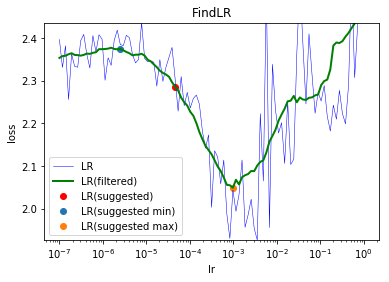

lr= 4.57088189614875e-05, lr_min=2.5118864315095806e-06, lr_max=0.00097723722095581


In [13]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	1.84505404	1.39399516	0.32542759	0.47760748	 138.687205
1	1.17716408	1.19374283	0.57742567	0.59464570	 138.164711
2	0.87898712	0.89714286	0.69189578	0.68113057	 138.077414
3	0.68275626	0.81129765	0.76448609	0.71596338	 139.090274
4	0.55695630	0.60631291	0.80864370	0.79667596	 139.110952
5	0.45052623	0.49461150	0.84279092	0.83260350	 139.157889
6	0.37020066	0.41148315	0.87040441	0.86315685	 138.982356
7	0.30047496	0.38320454	0.89504076	0.87211385	 138.755146
8	0.24271589	0.33969999	0.91590074	0.88823646	 139.066967
9	0.21450357	0.33076793	0.92551151	0.89132166	 139.818608


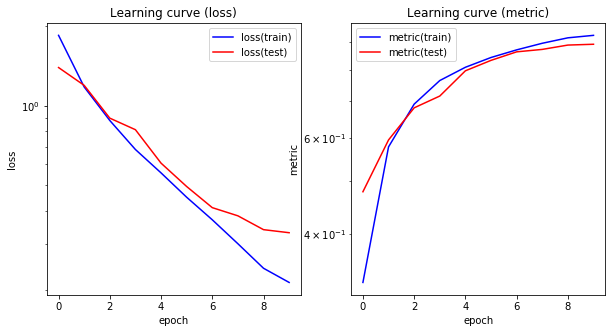

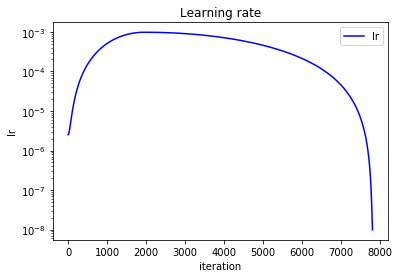

In [14]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

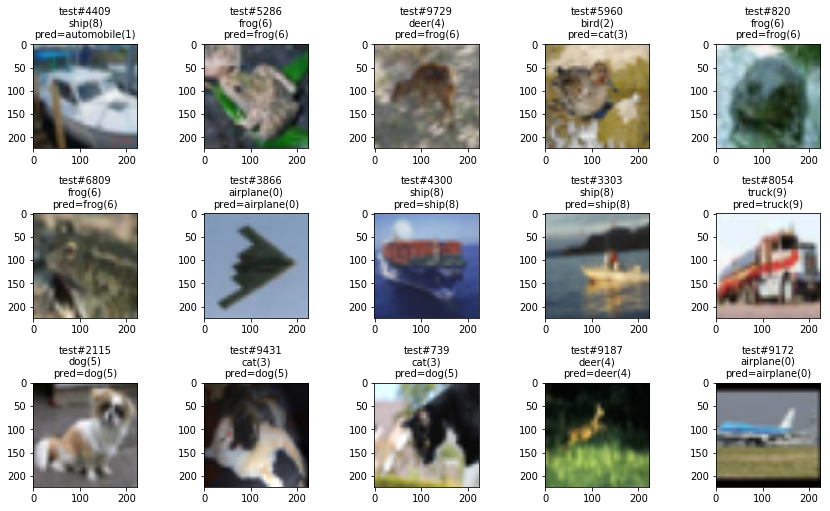

In [15]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)

## TResFlexNet2d(ResNetLC15)

In [28]:
#Setup a neural network.
kernel_size= 3
p_dropout= 0.0
rfn_args_resnetlc16= dict(
  kernel_size=kernel_size,
  layers=[
    ('Conv',dict(out_channels=32,stride=1)),
    ('Conv',dict(out_channels=32,stride=2)),
    ('Conv',dict(out_channels=64,stride=2)),
    torch.nn.MaxPool2d(kernel_size=kernel_size, stride=2, padding=kernel_size//2),
    ('Res',dict(out_channels=64,stride=1)),
    ('Res',dict(out_channels=64,stride=1)),
    ('Res',dict(out_channels=128,stride=1)),
    ('ResLC',dict(out_channels=128,stride=2)),
    ('Res',dict(out_channels=128,stride=1)),
    ('Res',dict(out_channels=128,stride=2)),
    ('Res',dict(out_channels=256,stride=1)),
    ('Res',dict(out_channels=256,stride=2)),
    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Dropout(p_dropout),
    ('Linear',dict(out_features=3)),
    ], )
in_shape= dset_train[0][0].shape
rfn_args_resnetlc16['layers'][-1][1]['out_features']= len(dset_train.classes)
net= TResFlexNet2d(in_shape, **rfn_args_resnetlc16)

device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
# f_loss= torch.nn.MSELoss()
f_loss= torch.nn.CrossEntropyLoss()

def decode(pred):
  return pred.max(1).indices

def accuracy(y,y_trg):
  return (decode(y)==y_trg).sum().item()/len(y_trg)
f_metric= accuracy

def tfm_batch(batch):
  x,y= batch
  return x,y
logger= TLogger()
disp= TDisp()

In [29]:
input_size= (1,)+dset_train[0][0].shape
Summary(net, input_size)

input_size=(1, 3, 224, 224)


Layer (type (var_name))                       Input Shape               Output Shape              Param #
TResFlexNet2d                                 --                        --                        --
├─Sequential (0)                              [1, 3, 224, 224]          [1, 32, 224, 224]         --
│    └─Conv2d (0)                             [1, 3, 224, 224]          [1, 32, 224, 224]         864
│    └─BatchNorm2d (1)                        [1, 32, 224, 224]         [1, 32, 224, 224]         64
│    └─ReLU (2)                               [1, 32, 224, 224]         [1, 32, 224, 224]         --
├─Sequential (1)                              [1, 32, 224, 224]         [1, 32, 112, 112]         --
│    └─Conv2d (0)                             [1, 32, 224, 224]         [1, 32, 112, 112]         9,216
│    └─BatchNorm2d (1)                        [1, 32, 112, 112]         [1, 32, 112, 112]         64
│    └─ReLU (2)                               [1, 32, 112, 112]         [1, 32, 11

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


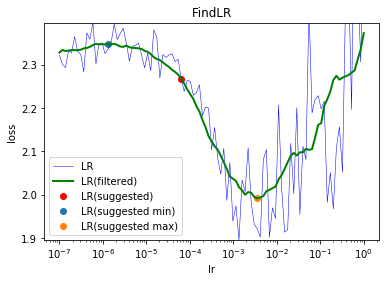

lr= 6.309573444801935e-05, lr_min=1.3182567385564072e-06, lr_max=0.003548133892335756


In [30]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
10	0.31826517	0.58379274	0.88964594	0.80324443	 140.094928
11	0.43566205	0.60540167	0.84788603	0.80254777	 140.974717
12	0.47495964	0.70852626	0.83401934	0.76253981	 139.974088
13	0.43363941	0.64695065	0.84978421	0.78980892	 140.532677
14	0.37508974	0.50548213	0.86910566	0.82842357	 138.516734
15	0.32241356	0.47616047	0.88784767	0.84832803	 138.540634
16	0.26209777	0.45307375	0.90910726	0.85479697	 138.857485
17	0.20849818	0.41021718	0.92790921	0.87101911	 138.510810
18	0.16806822	0.41677600	0.94269501	0.87261146	 138.781785
19	0.14610452	0.40512876	0.95124680	0.87549761	 138.596025


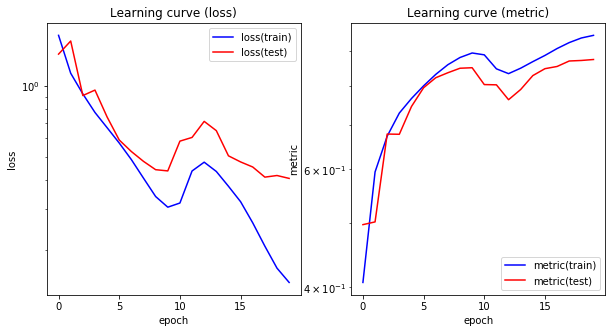

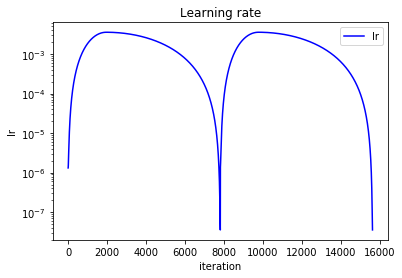

In [33]:
FitOneCycle(net, n_epoch=10, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

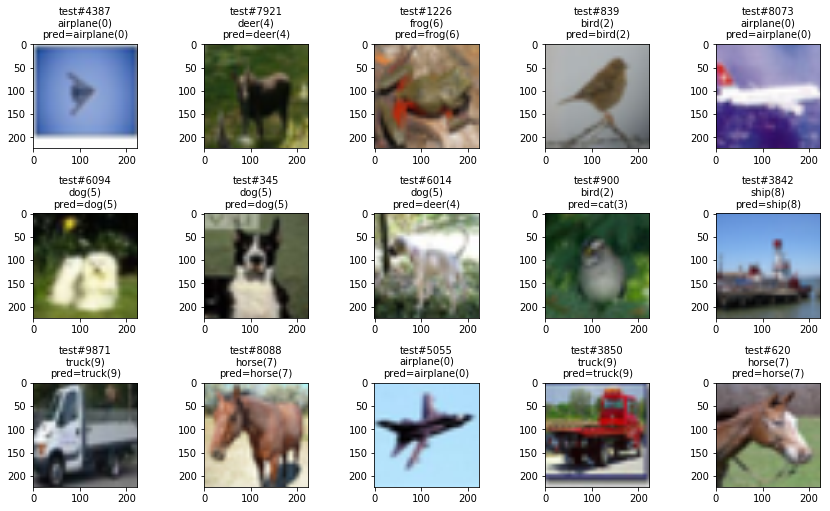

In [32]:
d= dset_test
idxes= np.random.permutation(len(d))[:15]
imgs= [d[i][0] for i in idxes]
pred= decode(Eval(net,imgs,device=device)).cpu()
labels= [f'test#{i}\n{d.classes[d[i][1]]}({d[i][1]})\npred={d.classes[lp]}({lp})' for i,lp in zip(idxes,pred)]
PlotImgGrid(imgs, labels)